In [1]:
import re
import numpy as np
import sys
from peft import LoraConfig, get_peft_model,PeftModel, PeftConfig
sys.path.append("/home/tsuchida/KLab_MultiModalModel/tsuchida_workdir/..")

from PIL import Image
import torch

/opt/conda/envs/kmmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def find_loc_index_combinations(s):  
    # 正規表現のパターンを更新: <loc_数字>の後に物体の名前も取得できるようにする
    pattern = r'<loc_(\d+)><loc_(\d+)>'
    
    # Find all matches in the given string  
    matches = re.findall(pattern, s)  
      
    valid_combinations = []  
      
    for match in matches:
        x_val, y_val = match

        valid_combinations.append((int(x_val), int(y_val)))
      
    return valid_combinations

def get_box_coords_from_index(P, ul_idx, lr_idx):  
    """  
    Given a grid of length P and the indices of the upper-left and lower-right corners of a bounding box,  
    returns the normalized coordinates of the bounding box, in the form [x1, y1, x2, y2].  
      
    Args:  
    - P (int): the length of the grid  
    - ul_idx (int): the index of the grid cell that corresponds to the upper-left corner of the bounding box  
    - lr_idx (int): the index of the grid cell that corresponds to the lower-right corner of the bounding box  
      
    Returns:  
    - box_coords (np.array of shape (4,)): the normalized coordinates of the bounding box, in the form [x1, y1, x2, y2]  
    """  
    # Compute the size of each cell in the grid  
    cell_size = 1.0 / P  
      
    # Compute the x and y indices of the upper-left and lower-right corners of the bounding box  
    ul_x = ul_idx % P  
    ul_y = ul_idx // P  
      
    lr_x = lr_idx % P  
    lr_y = lr_idx // P  
      
    # Compute the normalized coordinates of the bounding box  
    if ul_idx == lr_idx:  
        x1 = ul_x * cell_size  
        y1 = ul_y * cell_size  
        x2 = lr_x * cell_size + cell_size  
        y2 = lr_y * cell_size + cell_size  
    elif ul_x == lr_x or ul_y == lr_y:  
        x1 = ul_x * cell_size  
        y1 = ul_y * cell_size  
        x2 = lr_x * cell_size + cell_size  
        y2 = lr_y * cell_size + cell_size  
    else:  
        x1 = ul_x * cell_size + cell_size / 2  
        y1 = ul_y * cell_size + cell_size / 2  
        x2 = lr_x * cell_size + cell_size / 2  
        y2 = lr_y * cell_size + cell_size / 2  
      
    return np.array([x1, y1, x2, y2])

def decode_bbox_from_caption(caption, quantized_size=40, **kwargs):
    
    valid_combinations = find_loc_index_combinations(caption)
    # entity_names = list(valid_combinations)
    patch_index_coords = list(map(lambda pair: get_box_coords_from_index(quantized_size, pair[0], pair[1]), valid_combinations))
    collect_entity_location = []
    for patch_index_coord in patch_index_coords:
        collect_entity_location.append(patch_index_coord.tolist())
    
    return collect_entity_location

caption = "<loc_3><loc_1598>" 
print(find_loc_index_combinations(caption))
print(decode_bbox_from_caption(caption))



[(3, 1598)]
[[0.08750000000000001, 0.0125, 0.9625, 0.9875]]


##### 動作確認

In [4]:
if __name__ == "__main__":
    
    caption = "<loc_3><loc_1598> <loc_1><loc_1590>" 
    print(find_loc_index_combinations(caption))
    print(decode_bbox_from_caption(caption))

[(3, 1598), (1, 1590)]
[[0.08750000000000001, 0.0125, 0.9625, 0.9875], [0.037500000000000006, 0.0125, 0.7625, 0.9875]]


In [5]:
import os
from copy import deepcopy

import pandas as pd
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from data.dataset_loader import DatasetLoader

class VisualGenomeRefExpDataset(DatasetLoader):
    """openimageのdetectionデータセット
    """    
    def __init__(self,data_dir:str="/data01/visual_genome/",phase:str="train"):
        super().__init__()        
        if phase=="val":
            phase = "val"

        with open(os.path.join(data_dir,f"{phase}_ref_exp.tsv")) as f:
            items = f.read()

        
        items = items.split("\n")
        items = [item.split("\t") for item in items]
        items = items[1:10]
        # items = [item for item in items]
        items = [item for item in items if len(item)==3]
        self.src_texts = [f'Which regions does the text "{item[1]}" describe?' for item in items]
        self.tgt_texts = [item[2] for item in items]
        self.images = [os.path.join(data_dir,f"images_256",f"{item[0]}.png") for item in items]

In [6]:
train_dataset = VisualGenomeRefExpDataset(data_dir="/data01/visual_genome", phase="train")
val_dataset = VisualGenomeRefExpDataset(data_dir="/data01/visual_genome", phase="val")

In [7]:
from transformers import AutoTokenizer
from torchvision import transforms
# src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256)
src_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large", model_max_length=256, use_fast=True)

# tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(1000)] + [f"<img_{i}>" for i in range(args.image_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [8]:
import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu().numpy()
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)

  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_data(dataset, idx=10):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    tgt_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large", model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<loc_{i}>" for i in range(1600)])

    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        print('src_text:', src_text)
        print('tgt_text:', tgt_text)
        # src_text = src_tokenizer(src_text, padding="longest", max_length=256, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=256, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # print(src_text, tgt_text)

        img = custom_to_pil(src_image[0])
        
        img_width, img_height = img.size
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        bboxes =[]
        find_loc_index_combinations(tgt_text)
        bboxes = decode_bbox_from_caption(tgt_text)
        
        
        # 各bboxを描画
        for items in bboxes:
            # bboxの座標を実際の画像サイズにスケーリング
            x1, y1, x2, y2 = items
            x1 = x1 * img_width
            y1 = y1 * img_height
            x2 = x2 * img_width
            y2 = y2 * img_height
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # bboxの上にラベル（物体の名前）を表示
            # plt.text(x1, y1, label, bbox=dict(facecolor='red', alpha=0.5), fontsize=9, color='white')
    

        plt.show()
        # display(custom_to_pil(src_image[0]))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


src_text: Which regions does the text "the clock is green in colour" describe?
tgt_text: <loc_140><loc_504> <loc_260><loc_464>


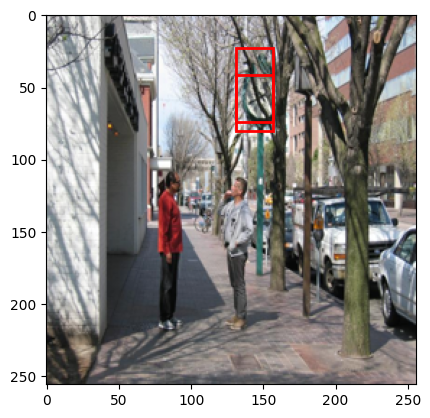

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


src_text: Which regions does the text "shade is along the street " describe?
tgt_text: <loc_969><loc_1258>


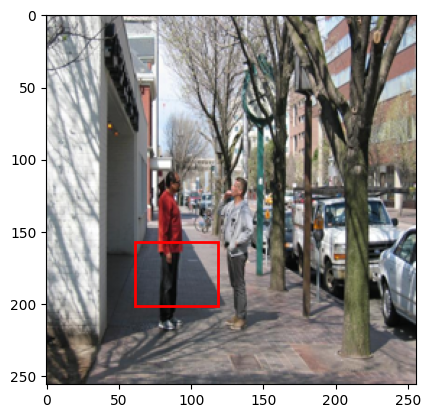

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


src_text: Which regions does the text "A man in a red shirt" describe?
tgt_text: <loc_651><loc_1334>


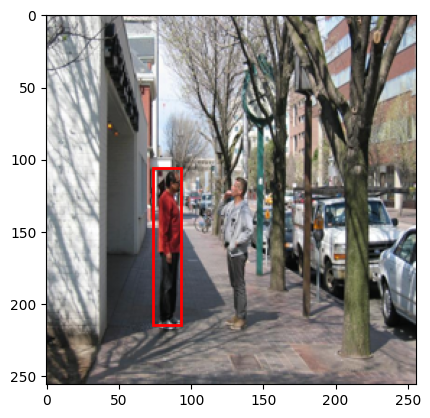

In [10]:
show_data(train_dataset, idx=0)
show_data(train_dataset, idx=1)
show_data(train_dataset, idx=5)

##### 学習したものを可視化

In [11]:
import argparse
args = argparse.Namespace(
    # Model setting
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-large",
    transformer_model_name="google/flan-t5-base",
    ffn=True,
    phase = "train",
    transformer_d_model=768,
    transformer_d_ff=3072,
    # transformer_d_model=1024,
    # transformer_d_ff=4096,
    transformer_d_kv=64,
    transformer_num_heads=12,
    transformer_num_layers=2,
    transformer_num_decoder_layers=12,
    image_vocab_size=16384,
    loc_vocab_size=1600,
    vae_ckpt_path="checkpoints/vqgan.pt",
    max_source_length=256,
    max_target_length=256,
    # Train setting
    pretrain="train", 
    # Dir setting
    root_dir="/data01/",
    result_dir="results/",
    loss = "CrossEntropy",
    loc_learn = "lora",
    float_type = 'bfloat16',
    lora_r = 16,
    lora_alpha = 16,
    lora_dropout = 0.1,
    lora_bias = "none"
)



In [12]:
from peft.utils.other import ModulesToSaveWrapper
class ExtendedModulesToSaveWrapper(ModulesToSaveWrapper):
    def __init__(self, module_to_save, adapter_name):
        super().__init__(module_to_save, adapter_name)
        self.main_input_name = "input_embeds" # ここでPeftModelの適切な入力名を設定する

# wrapper_instance = ExtendedModulesToSaveWrapper(module_to_save, adapter_name)     

In [13]:

from models.model import MyModel
model = MyModel(args).to(device)
print(model)
tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_target_length, use_fast=True, extra_ids=0, additional_special_tokens =[f"<loc_{i}>" for i in range(args.loc_vocab_size)])
model.transformer.resize_token_embeddings(len(tgt_tokenizer))

path = "/home/tsuchida/KLab_MultiModalModel/results/loc/lora/bf16/qkv/1e-5/openimage/1e-5lambda/enc2_dec12/epoch_40.pth"
# path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/scratch/openimage/enc2_dec12/epoch_40.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/scratch/openimage/enc2_dec12/best.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/lora/openimage/enc2_dec12/epoch_30.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/lora/1e-4/openimage/enc2_dec12/bestLora"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/lora/bf16/scratch/1e-4/openimage/enc2_dec12/best.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/scratch/1e-4/openimage/enc0_dec12/bestLora"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/scratch/1e-4/openimage/enc0_dec12/epoch_10.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/sample/openimage/1e-5lambda/enc0_dec12/bestLora"
path = "/home/tsuchida/KLab_MultiModalModel/results/lora/vg/visual_genome_refexp/enc2_dec24/epoch_4"
path = "/home/tsuchida/KLab_MultiModalModel/results/scratch/visual_genome_refexp/enc2_dec24/epoch_2.pth"

# train
path = "/home/tsuchida/KLab_MultiModalModel/results/scratch/base/visual_genome_refexp/enc2_dec12/epoch_50.pth"
# lora
path = "/home/tsuchida/KLab_MultiModalModel/results/lora/base/vg/visual_genome_refexp/enc2_dec12/epoch_50"
if (args.loc_learn == "lora"):
    model = PeftModel.from_pretrained(model, path)
else:
    model.load(result_name=path)
# model = set_peft_model_state_dict(model, path)
# model = PeftModel.from_pretrained(model, path)
print(model)
model.eval()

T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "max_length": 256,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 2,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
    

PeftModel(
  (base_model): LoraModel(
    (model): MyModel(
      (language_model): T5EncoderModel(
        (shared): Embedding(32128, 1024)
        (encoder): T5Stack(
          (embed_tokens): Embedding(32128, 1024)
          (block): ModuleList(
            (0): T5Block(
              (layer): ModuleList(
                (0): T5LayerSelfAttention(
                  (SelfAttention): T5Attention(
                    (q): Linear(in_features=1024, out_features=1024, bias=False)
                    (k): Linear(in_features=1024, out_features=1024, bias=False)
                    (v): Linear(in_features=1024, out_features=1024, bias=False)
                    (o): Linear(in_features=1024, out_features=1024, bias=False)
                    (relative_attention_bias): Embedding(32, 16)
                  )
                  (layer_norm): T5LayerNorm()
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (1): T5LayerFF(
                  (DenseReluDense):

In [14]:
def show_result(dataset, idx=10):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        tgt_text2 = tgt_text
        print('src_text:', src_text)
        print('tgt_text:', tgt_text)
        src_text = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=args.max_target_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # print(src_text, tgt_text)

        # display(custom_to_pil(src_image[0]))
        src_attention_masks = torch.ones_like(src_text, device=device, dtype=torch.bool)
        src_attention_masks[src_text == 0] = 0
        tgt_attention_masks = torch.ones_like(tgt_text, device=device, dtype=torch.bool)
        tgt_attention_masks[tgt_text == 0] = 0
        preds= model(src_image, src_text, src_attention_masks, tgt_text, tgt_attention_masks,return_loss=False)

        # print(loss)
        preds = tgt_tokenizer.batch_decode(preds[:,1:-1])
        print('pred:', preds[0])
        print(type(preds))
        img = custom_to_pil(src_image[0])
        
        img_width, img_height = img.size
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        bboxes =[]
        find_loc_index_combinations(preds[0])
        bboxes = decode_bbox_from_caption(preds[0])
        
        tgt_box =[]
        find_loc_index_combinations(tgt_text2)
        tgt_box = decode_bbox_from_caption(tgt_text2)
        
        # 各bboxを描画
        for item in tgt_box:
            # bboxの座標を実際の画像サイズにスケーリング
            x1, y1, x2, y2 = item
            x1 = x1 * img_width
            y1 = y1 * img_height
            x2 = x2 * img_width
            y2 = y2 * img_height
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
            # bboxの上にラベル（物体の名前）を表示
            # plt.text(x1, y1, label, bbox=dict(facecolor='green', alpha=0.5), fontsize=9, color='white')
        
        for items in bboxes:
            # bboxの座標を実際の画像サイズにスケーリング
            x1, y1, x2, y2 = items
            x1 = x1 * img_width
            y1 = y1 * img_height
            x2 = x2 * img_width
            y2 = y2 * img_height
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect)
            
            # bboxの上にラベル（物体の名前）を表示
            # plt.text(x1, y1, label, bbox=dict(facecolor='yellow', alpha=0.5), fontsize=9, color='black')
    
        
        plt.axis('off')
        plt.show()
        # preds = src_tokenizer.batch_decode(output[:,1:-1])


src_text: Which regions does the text "the clock is green in colour" describe?
tgt_text: <loc_140><loc_504> <loc_260><loc_464>
pred: <loc_260><loc_502>
<class 'list'>


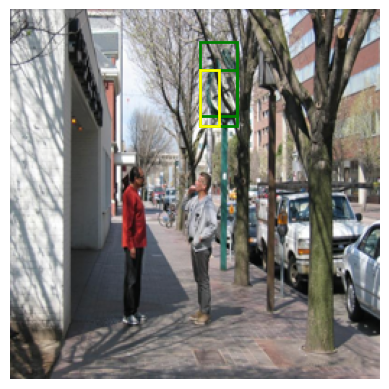

src_text: Which regions does the text "shade is along the street " describe?
tgt_text: <loc_969><loc_1258>
pred: <loc_1048><loc_1558>
<class 'list'>


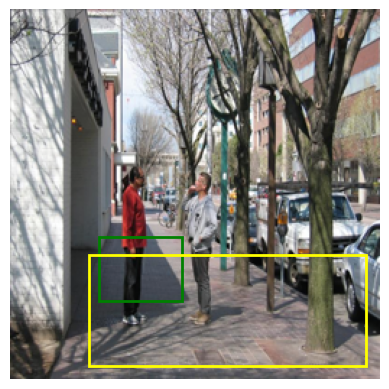

src_text: Which regions does the text "A man in a red shirt" describe?
tgt_text: <loc_651><loc_1334>
pred: <loc_611><loc_1558>
<class 'list'>


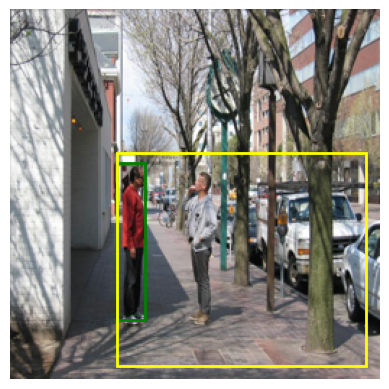

src_text: Which regions does the text "multi-line office phone system" describe?
tgt_text: <loc_867><loc_1153>
pred: <loc_745><loc_915>
<class 'list'>


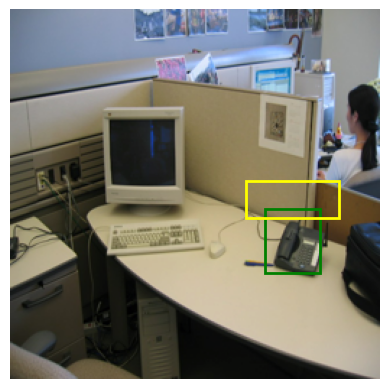

src_text: Which regions does the text "electrical and data line outlets" describe?
tgt_text: <loc_602><loc_767>
pred: <loc_523><loc_518>
<class 'list'>


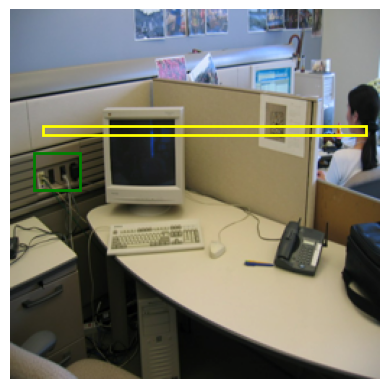

src_text: Which regions does the text "A computer keyboard and mouse" describe?
tgt_text: <loc_849><loc_1062>
pred: <loc_854><loc_1558>
<class 'list'>


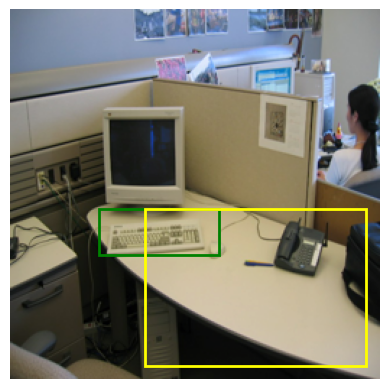

In [15]:
show_result(train_dataset, idx=0)
show_result(train_dataset, idx=1)
show_result(train_dataset, idx=5)
show_result(val_dataset, idx=0)
show_result(val_dataset, idx=1)
show_result(val_dataset, idx=5)

In [16]:
src_tokenizer.encode('Whale')

[30300, 1]